#data import

In [164]:
# Native libraries
import os
import math
# Essential Libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# Preprocessing
from sklearn.preprocessing import MinMaxScaler
# Algorithms
from minisom import MiniSom
from tslearn.barycenters import dtw_barycenter_averaging
from tslearn.clustering import TimeSeriesKMeans
from sklearn.cluster import KMeans

from sklearn.decomposition import PCA

In [165]:
import yfinance as yf
from analysis.data.utils_analysis import create_full_dataset
snp500url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
data_tab = pd.read_html(snp500url)

tickers = data_tab[0][1:]['Symbol'].tolist()
# from analysis.data.utils_analysis import create_full_dataset
# ESG = pd.read_csv(r"C:\Users\m.narese\Desktop\THESIS\REPO\portfolio_optimization\analysis\datasets\1\ESG_data.csv")
# # tickers = list(ESG['ticker'].unique())
print("Total number of tickers", len(tickers))

raw = yf.download(tickers, start="2016-01-01", end="2023-01-01", auto_adjust=True)

[                       0%                       ]

Total number of tickers 502


[*********************100%***********************]  502 of 502 completed

7 Failed downloads:
['GEV', 'SW', 'KVUE', 'VLTO', 'SOLV']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2016-01-01 -> 2023-01-01) (Yahoo error = "Data doesn\'t exist for startDate = 1451624400, endDate = 1672549200")')
['BRK.B']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
['BF.B']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2016-01-01 -> 2023-01-01)')


In [166]:
import json
location = r"C:\Users\m.narese\Desktop\THESIS\REPO\portfolio_optimization\analysis\datasets\esg_data.json"

with open(location, "r") as file:
    esg_data = json.load(file)  # Parse JSON into a Python dictionary or list

rows = []
for entry in esg_data:
    ticker = entry['ticker']
    esgScores = entry.get('esgScores')
    if esgScores:
        rows.append({
            'ticker': ticker,
            'totalEsg': esgScores.get('totalEsg'),
            'environmentScore': esgScores.get('environmentScore'),
            'socialScore': esgScores.get('socialScore'),
            'governanceScore': esgScores.get('governanceScore')
        })
    else:
        rows.append({
            'ticker': ticker,
            'totalEsg': None,
            'environmentScore': None,
            'socialScore': None,
            'governanceScore': None
        })
# Create DataFrame
esg_df = pd.DataFrame(rows)

esg_df

,ticker,totalEsg,environmentScore,socialScore,governanceScore
0,AOS,26.82,6.65,13.55,6.61
1,ABT,22.21,1.81,13.84,6.56
2,ABBV,26.10,1.78,15.70,8.62
3,ACN,11.09,0.14,6.94,4.01
4,ADBE,14.06,1.69,7.23,5.14
...,...,...,...,...,...
497,XYL,22.86,10.49,8.01,4.36
498,YUM,20.51,7.04,10.25,3.22
499,ZBRA,9.94,1.79,3.34,4.81
500,ZBH,26.19,4.89,13.99,7.31


In [167]:
dataset = pd.DataFrame(raw)
missing_frac = dataset.isnull().mean().sort_values(ascending=False)
drop_list = sorted(list(missing_frac[missing_frac > 0.2].index))
dataset.drop(columns=drop_list, axis = 1, inplace=True)
dataset.bfill(axis='index', inplace=True)
print('Null values:', dataset.isnull().values.any())
print('NaN values:', dataset.isna().values.any())

Null values: False
NaN values: False


In [136]:
import quantstats as qs

def data_vertical(data):
    dataset_vertical = data.stack(level=1).reset_index()
    dataset_vertical.rename(columns={'level_1': 'Ticker'}, inplace=True)
    dataset_vertical['Date'] = pd.to_datetime(dataset_vertical['Date']) 
    dataset_vertical.set_index('Date', inplace=True)
    return dataset_vertical
    


def feature_engineering(data):
    #avg returns
    returns = data["Close"].pct_change().mean()*252
    returns = pd.DataFrame(returns)
    final_dataframe = returns.reset_index()
    final_dataframe = final_dataframe.rename(columns={final_dataframe.columns[1]:"Yavg_return"})
    #volatility
    final_dataframe["Yavg_volatility"] = np.array(data["Close"].pct_change().std()*np.sqrt(252))

    dataset_vertical = data_vertical(data)
    dataset_vertical["daily_span"] = dataset_vertical["High"]- dataset_vertical["Low"]
    #daily_span
    final_dataframe["Davg_span"] = np.array(dataset_vertical.groupby("Ticker")["daily_span"].mean())
    #traded volume
    final_dataframe["Davg_volume"] = np.array(dataset_vertical.groupby("Ticker")["Volume"].mean())
    #skewness
    final_dataframe["D_eSkewness"] = np.array(dataset_vertical.groupby("Ticker")["Close"].apply(qs.stats.skew))

    #VaR
    final_dataframe["D_eVaR"] = np.array(dataset_vertical.groupby("Ticker")["Close"].apply(qs.stats.value_at_risk))/(np.array(dataset_vertical.groupby("Ticker")["Close"].mean()))
    #CVaR
    final_dataframe["D_eCVaR"] = np.array(dataset_vertical.groupby("Ticker")["Close"].apply(qs.stats.expected_shortfall))/(np.array(dataset_vertical.groupby("Ticker")["Close"].mean()))
    #Curtosis
    final_dataframe["D_eCurtosis"] = np.array(dataset_vertical.groupby("Ticker")["Close"].apply(qs.stats.kurtosis))

    return final_dataframe
fdata = feature_engineering(dataset)

C:\Users\m.narese\AppData\Local\Temp\ipykernel_11316\3511727479.py:4: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  dataset_vertical = data.stack(level=1).reset_index()


In [137]:
from analysis.data.utils_analysis import create_full_dataset
ESG = pd.read_csv(r"C:\Users\m.narese\Desktop\THESIS\REPO\portfolio_optimization\analysis\datasets\1\ESG_data.csv")
stock_data = create_full_dataset(fdata, esg_df)
stock_data = create_full_dataset(stock_data, ESG)
stock_data = stock_data.drop(columns=["logo", "name", "weburl", "exchange", "last_processing_date", "cik", "currency", 
                                    "environment_grade",
                                    "environment_level",
                                    "social_grade",
                                    "social_level",
                                    "governance_grade",
                                    "governance_level",
                                    "environment_score",
                                    "social_score",
                                    "governance_score",
                                    "total_score",
                                    "total_grade",
                                    "total_level"])
print(f"The dataset has {stock_data.shape[0]} assets")
print(f"The dataset has {stock_data.shape[1]-1} predictors:")
for i in stock_data.columns:
    print(i)

The dataset has 480 assets
The dataset has 13 predictors:
Ticker
Yavg_return
Yavg_volatility
Davg_span
Davg_volume
D_eSkewness
D_eVaR
D_eCVaR
D_eCurtosis
totalEsg
environmentScore
socialScore
governanceScore
industry


C:\Users\m.narese\AppData\Local\Temp\ipykernel_16100\3511727479.py:4: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  dataset_vertical = data.stack(level=1).reset_index()


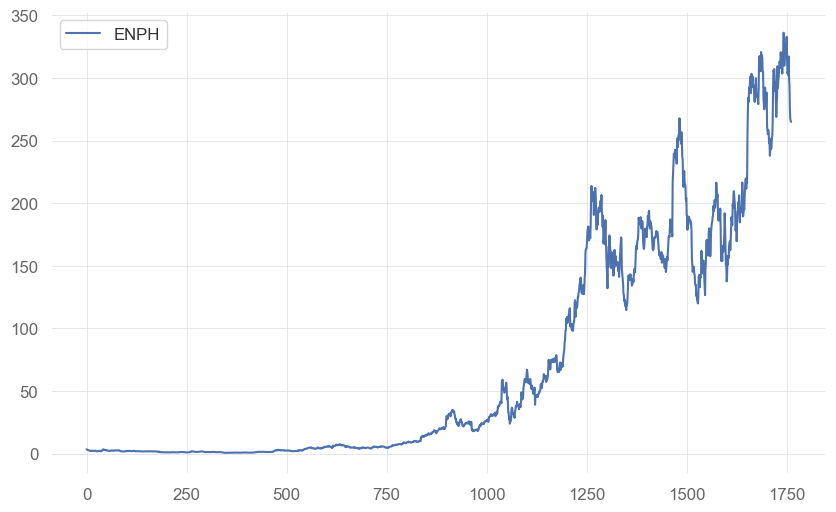

In [18]:
outliers = stock_data[
    (stock_data["Yavg_volatility"] > 0.7)]["Ticker"].unique()
i = 0
ds = data_vertical(dataset)
# plt.subplot(2,1,1)
for asset in outliers:
    prices = np.array(ds[ds["Ticker"] == asset]["Close"])
    plt.plot(prices, label = asset, color = f"C{i}")
    plt.legend()
    i += 1

stock_data = stock_data[~stock_data["Ticker"].isin(outliers)].dropna()
# plt.subplot(2,1,2)
# prices = np.array(ds[ds["Ticker"] == "ADTX"]["Close"])
# plt.plot(prices, label="ADTX", color = f"C{i}")
# plt.legend()
# plt.show()

In [171]:
sd = "2016-01-01"
ed = "2023-01-01"
ts_data_s= yf.download(tickers=list(stock_data["Ticker"]), start=sd, end=ed, auto_adjust=True)["Close"]

[*********************100%***********************]  480 of 480 completed


In [172]:
ts_data = pd.DataFrame(ts_data_s)
missing_frac = ts_data.isnull().mean().sort_values(ascending=False)
drop_list = sorted(list(missing_frac[missing_frac > 0.2].index))
ts_data.drop(columns=drop_list, axis = 1, inplace=True)
ts_data.bfill(axis='index', inplace=True)
print('Null values:', ts_data.isnull().values.any())
print('NaN values:', ts_data.isna().values.any())

Null values: False
NaN values: False


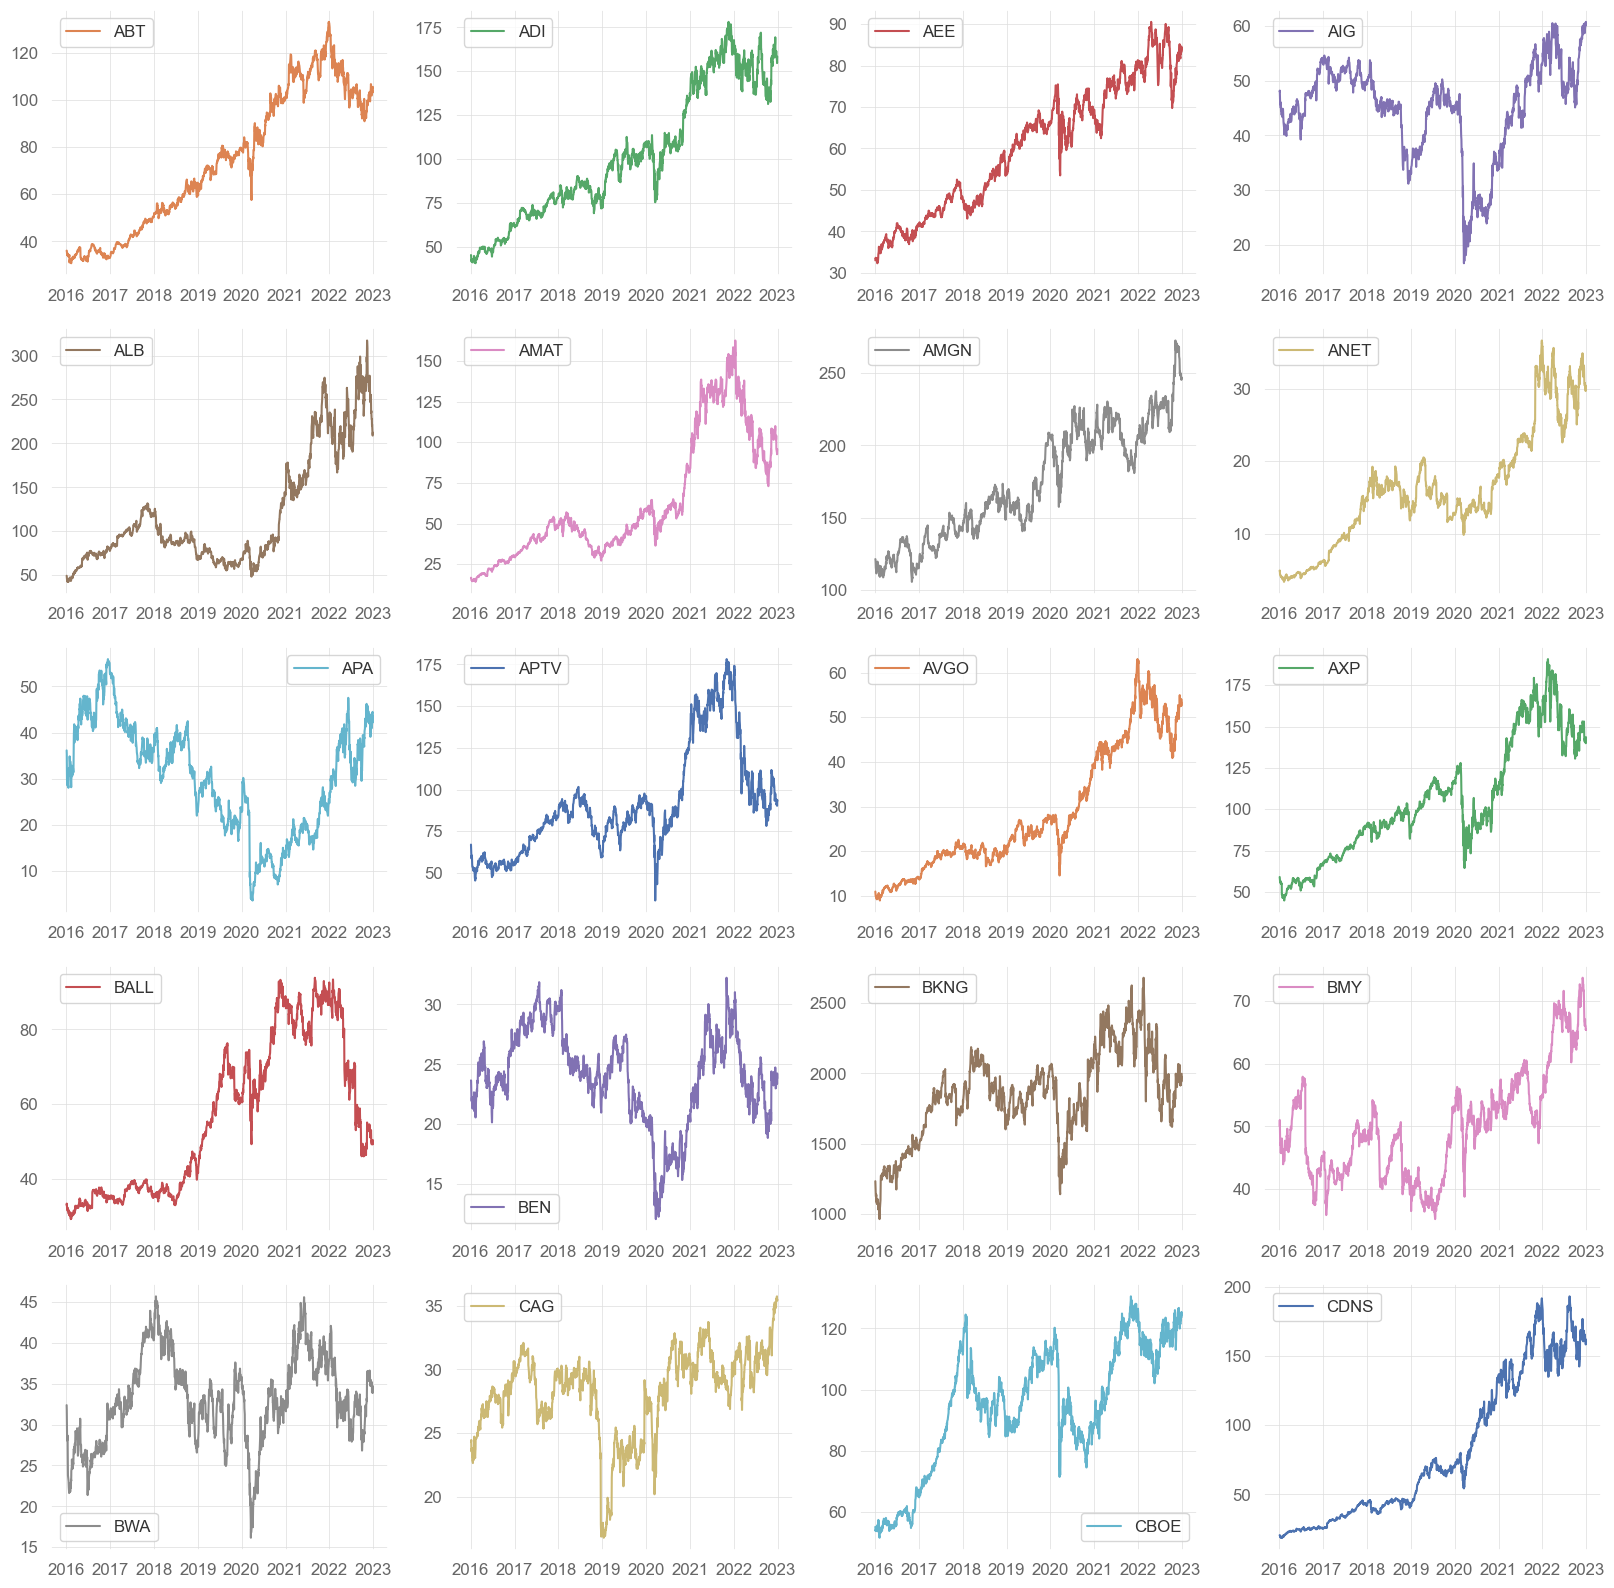

In [173]:
plt.figure(figsize=(20,20))
for i in range(1, 21):
    plt.subplot(5,4,i)
    ticker = ts_data.reset_index().columns[i*4]
    plt.plot(ts_data.reset_index()["Date"], ts_data.reset_index()[ticker], label = ticker, color = f"C{i}")
    plt.legend()
plt.show()



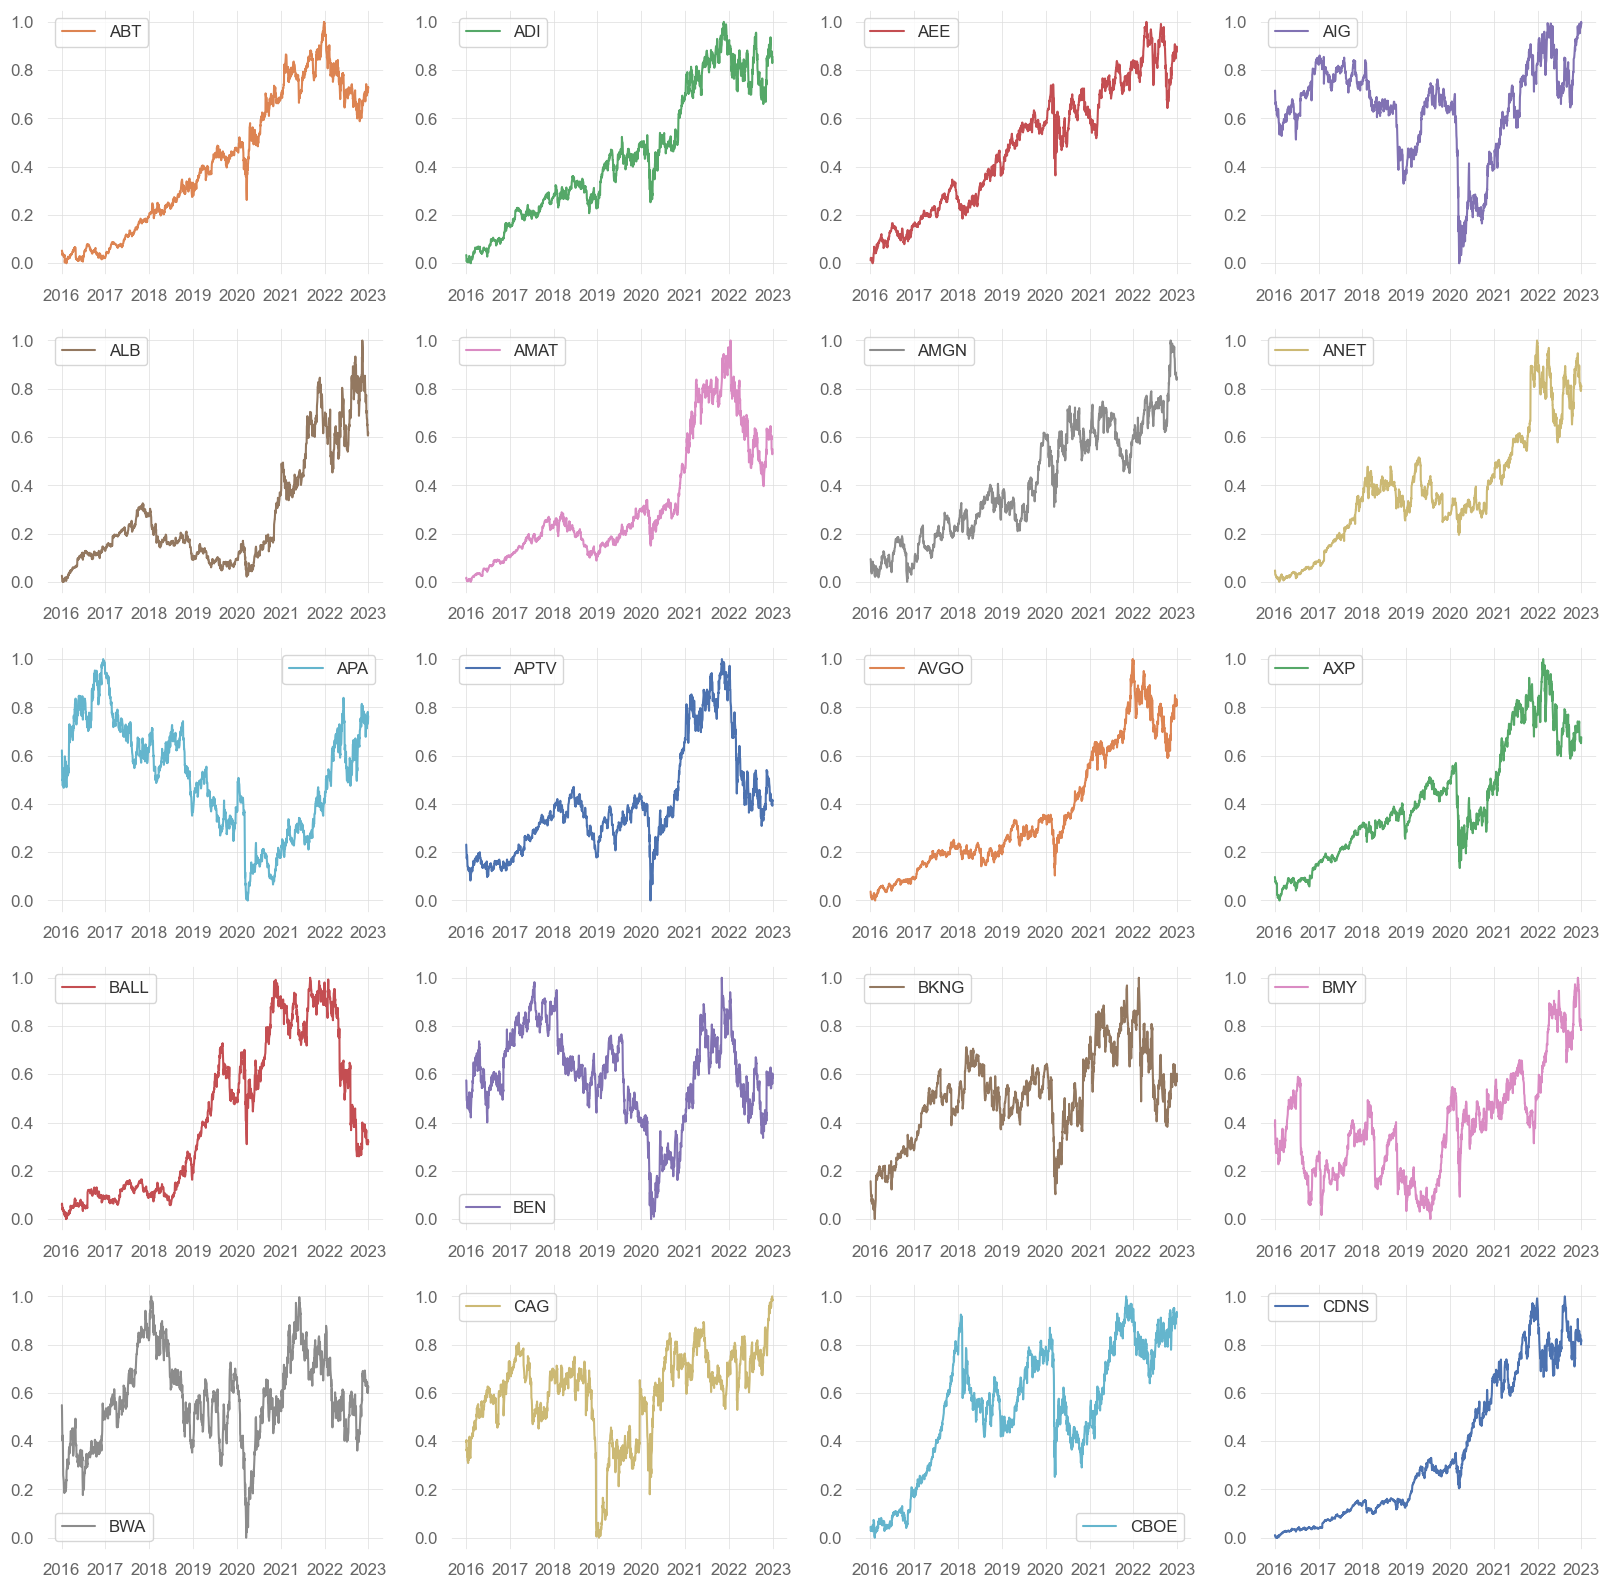

In [174]:
names = ts_data.columns
for ticker in names:
    scaler = MinMaxScaler()
    ts_data[ticker] = scaler.fit_transform(ts_data[ticker].values.reshape(-1, 1)).flatten()
plt.figure(figsize=(20,20))
for i in range(1, 21):
    plt.subplot(5,4,i)
    ticker = ts_data.reset_index().columns[i*4]
    plt.plot(ts_data.reset_index()["Date"], ts_data.reset_index()[ticker], label = ticker, color = f"C{i}")
    plt.legend()
plt.show()


In [175]:

som_x = som_y = 3 #int(np.ceil(np.sqrt(total_map)))
# I didn't see its significance but to make the map square,
# I calculated square root of map size which is 
# the square root of the number of series
# for the row and column counts of som

som = MiniSom(som_x, som_y, ts_data.shape[0], sigma=0.2, learning_rate = 0.5)

som.random_weights_init(ts_data.values.T)
som.train(ts_data.values.T, 200000)

In [176]:
def plot_som_series_averaged_center(som_x, som_y, win_map):
    fig, axs = plt.subplots(som_x,som_y,figsize=(25,25))
    fig.suptitle('Clusters')
    for x in range(som_x):
        for y in range(som_y):
            cluster = (x,y)
            if cluster in win_map.keys():
                for series in win_map[cluster]:
                    axs[cluster].plot(series,c="gray",alpha=0.5) 
                axs[cluster].plot(np.average(np.vstack(win_map[cluster]),axis=0),c="red")
            cluster_number = x*som_y+y+1
            axs[cluster].set_title(f"Cluster {cluster_number}")

    plt.show()

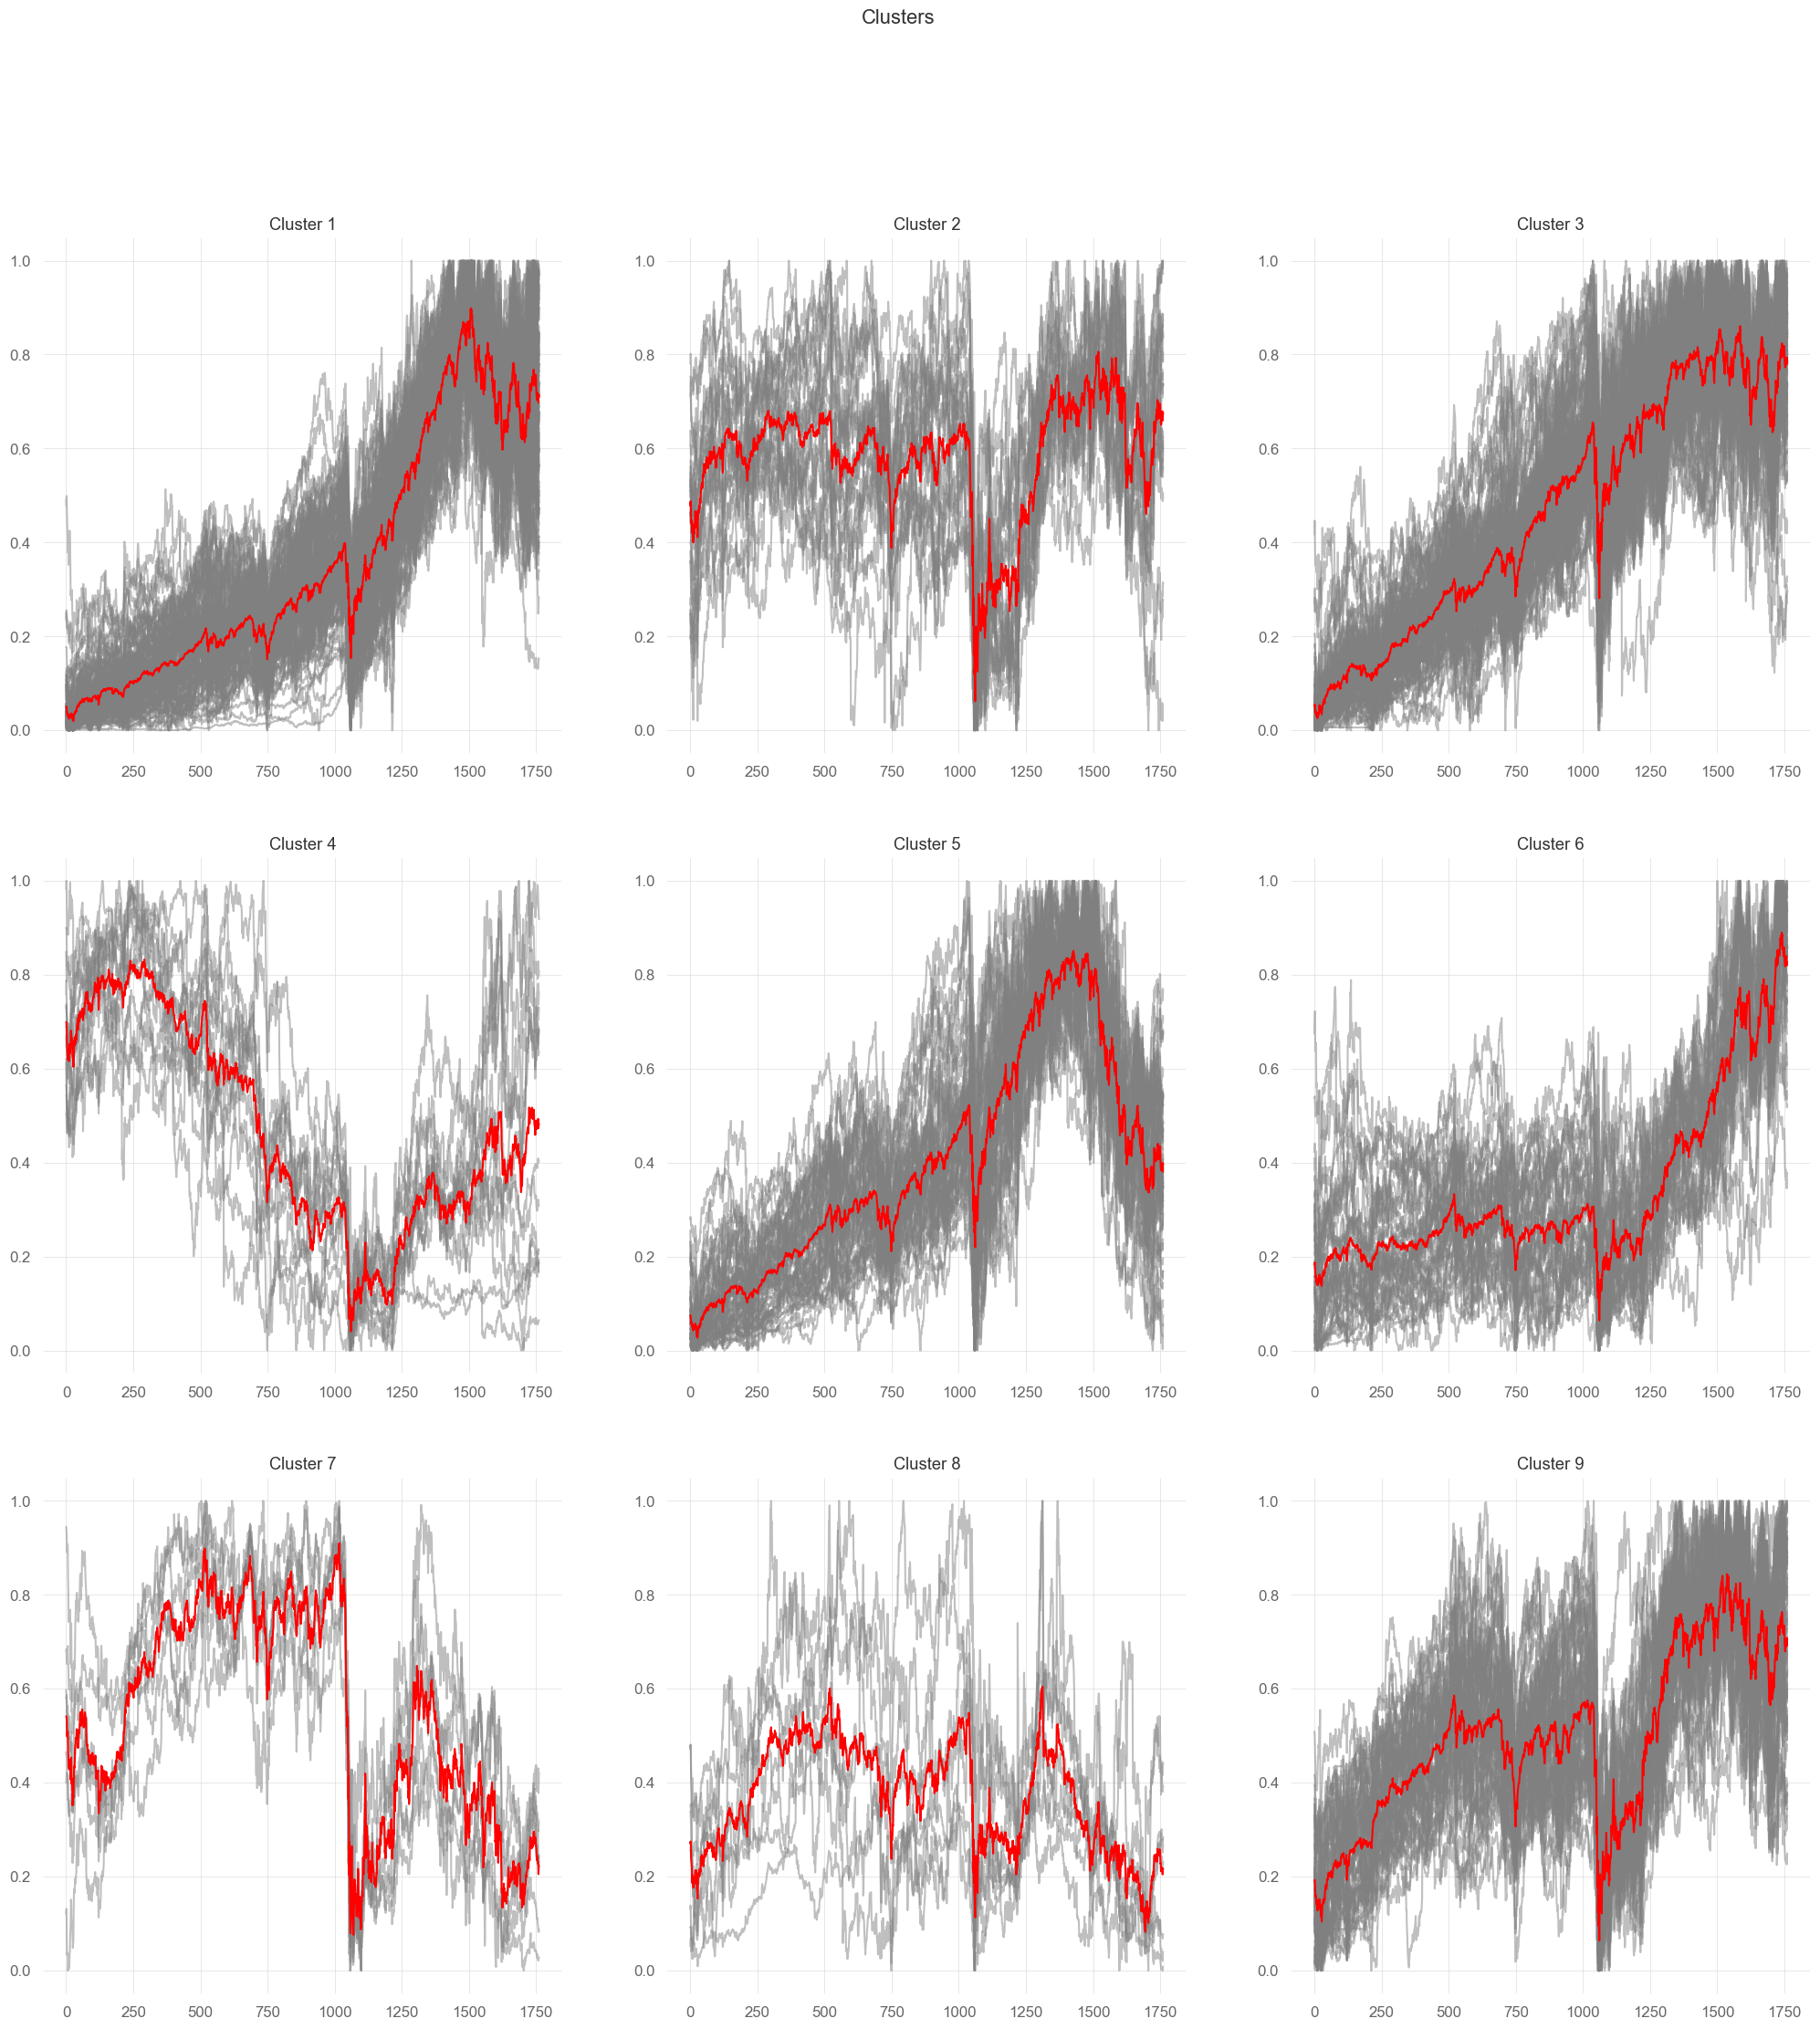

In [177]:
win_map = som.win_map(ts_data.values.T)
# Returns the mapping of the winner nodes and inputs

plot_som_series_averaged_center(som_x, som_y, win_map)

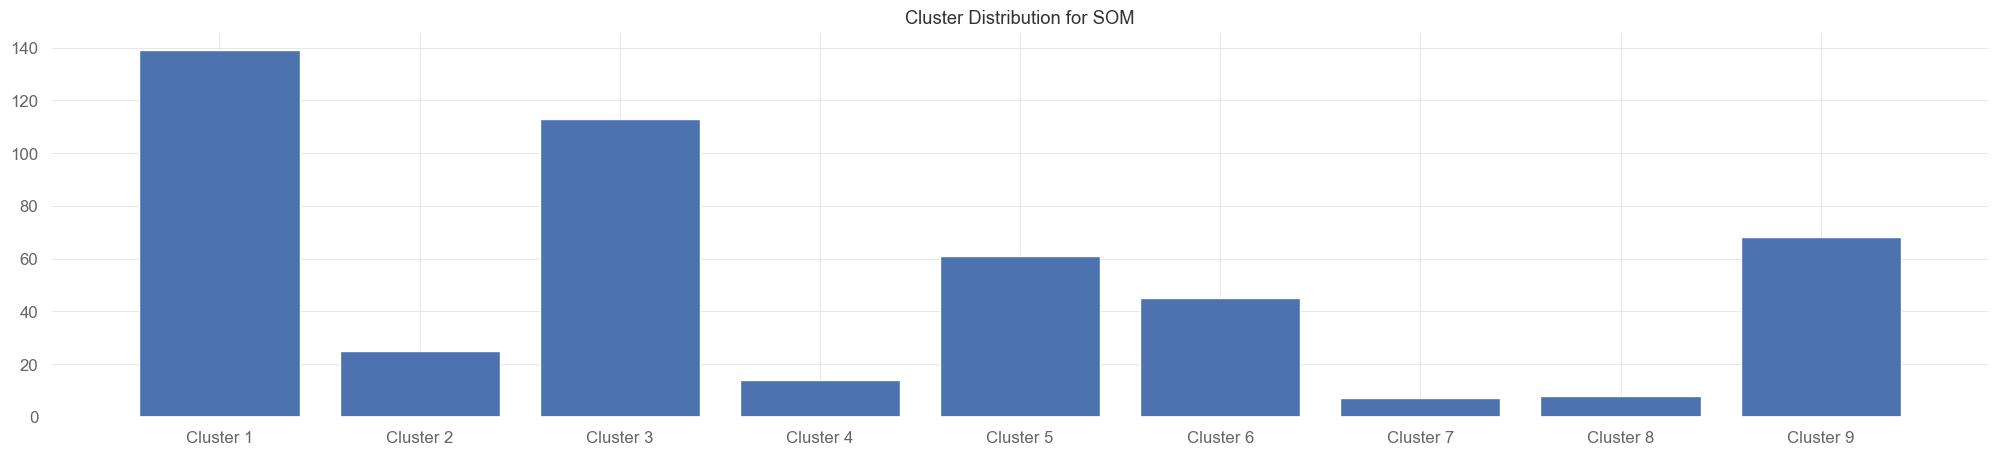

In [178]:
cluster_c = []
cluster_n = []
for x in range(som_x):
    for y in range(som_y):
        cluster = (x,y)
        if cluster in win_map.keys():
            cluster_c.append(len(win_map[cluster]))
        else:
            cluster_c.append(0)
        cluster_number = x*som_y+y+1
        cluster_n.append(f"Cluster {cluster_number}")

plt.figure(figsize=(25,5))
plt.title("Cluster Distribution for SOM")
plt.bar(cluster_n,cluster_c)
plt.show()

In [181]:
cluster_map = {}
for idx in names:
    winner_node = som.winner(np.array(ts_data[idx]))
    cluster_map[idx] = winner_node[0]*som_y+winner_node[1]+1


In [182]:
stock_data['Sector'] = stock_data['Ticker'].map(cluster_map)
stock_data

,Ticker,Yavg_return,Yavg_volatility,Davg_span,Davg_volume,D_eSkewness,D_eVaR,D_eCVaR,D_eCurtosis,totalEsg,environmentScore,socialScore,governanceScore,industry,Sector
0,A,0.231620,0.271466,1.761373,1.979893e+06,-0.248165,-0.000320,-0.000468,4.864299,11.36,1.19,6.23,3.93,Life Sciences Tools and Services,1
1,AAPL,0.287298,0.303828,1.752841,1.209567e+08,-0.024156,-0.000394,-0.000586,5.374823,16.79,0.55,7.52,8.72,Technology,1
2,ABBV,0.228479,0.270974,1.647473,7.382030e+06,-0.655546,-0.000354,-0.000588,12.704373,26.10,1.78,15.70,8.62,Biotechnology,6
3,ABT,0.184229,0.249523,1.414195,6.388588e+06,-0.241472,-0.000341,-0.000534,6.772868,22.21,1.81,13.84,6.56,Health Care,3
4,ACGL,0.185249,0.286301,0.683120,1.675522e+06,-0.311839,-0.000880,-0.001469,14.864780,20.27,1.57,9.92,8.78,Insurance,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475,XYL,0.213259,0.284470,1.540006,1.086327e+06,-0.078628,-0.000392,-0.000629,7.073121,22.86,10.49,8.01,4.36,Machinery,5
476,YUM,0.176554,0.241725,1.471566,2.303611e+06,1.681850,-0.000286,-0.000459,36.441131,20.51,7.04,10.25,3.22,Hotels Restaurants and Leisure,3
477,ZBH,0.087482,0.293944,2.519078,1.379612e+06,0.191068,-0.000256,-0.000414,10.353046,26.19,4.89,13.99,7.31,Health Care,5
478,ZBRA,0.272658,0.398210,6.673275,4.406926e+05,-0.010850,-0.000170,-0.000266,8.102569,9.94,1.79,3.34,4.81,Electrical Equipment,5


In [216]:
cluster_profile = stock_data.groupby("Sector").mean(numeric_only=True)

# Add counts for the number of stocks in each cluster
cluster_profile["Count"] = stock_data.groupby("Sector")["Ticker"].count().values
cluster_profile["Sharpe_ratio"] = (cluster_profile["Yavg_return"]-0.02)/cluster_profile["Yavg_volatility"]
cluster_profile.style.highlight_max(color="green", axis=0)

,Yavg_return,Yavg_volatility,Davg_span,Davg_volume,D_eSkewness,D_eVaR,D_eCVaR,D_eCurtosis,totalEsg,environmentScore,socialScore,governanceScore,Count,Sharpe_ratio
Sector,,,,,,,,,,,,,,
1,0.238532,0.324433,2.961995,9952203.385958,0.037692,-0.000585,-0.000907,14.747592,17.914348,3.986159,8.285725,5.642826,139,0.673582
2,0.077367,0.333399,1.176758,4566176.499024,0.064980,-0.001002,-0.001619,18.010527,19.603600,5.352400,8.548800,5.703600,25,0.172069
3,0.175662,0.270395,3.161809,3187507.823421,-0.069985,-0.000380,-0.000605,13.651064,21.520357,6.735804,9.542768,5.241339,113,0.575683
4,0.060966,0.441045,1.255599,7510254.871169,-0.353893,-0.001283,-0.002120,21.207559,25.853571,10.685000,9.681429,5.484286,14,0.092883
5,0.166273,0.344774,3.553605,5600206.886241,-0.087967,-0.000452,-0.000700,10.956497,18.883833,4.850167,8.818667,5.215833,61,0.424256
6,0.188375,0.342517,1.917727,5945624.579115,-0.154768,-0.001165,-0.001929,11.148358,24.090444,9.286818,9.196818,5.688636,45,0.491583
7,0.045374,0.509786,1.501449,10292137.854711,0.010224,-0.001108,-0.001845,12.485491,23.824286,7.688571,11.270000,4.865714,7,0.049773
8,0.062012,0.426670,2.993662,10224504.576405,0.346297,-0.000834,-0.001341,19.241849,21.186250,2.710000,11.972500,6.502500,8,0.098465
9,0.142398,0.339364,2.232280,4708133.279153,-0.201236,-0.000879,-0.001440,16.078626,21.741765,6.052353,9.436176,6.252794,68,0.360668


In [185]:
benchmark = yf.download(tickers="SPY", start=sd, end=ed, auto_adjust=True)["Close"]

[*********************100%***********************]  1 of 1 completed


In [ ]:

portfolio_data_trained = yf.download(tickers=list(stock_data["Ticker"]), start=sd, end=ed, auto_adjust=True)["Close"]

[*********************100%***********************]  480 of 480 completed

1 Failed download:
['EXC']: ConnectionError(ProtocolError('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')))


In [ ]:
portfolio_dataset = pd.DataFrame(portfolio_data_trained)
missing_frac = portfolio_dataset.isnull().mean().sort_values(ascending=False)
drop_list = sorted(list(missing_frac[missing_frac > 0.1].index))
portfolio_dataset.drop(columns=drop_list, axis = 1, inplace=True)
portfolio_dataset.bfill(axis='index', inplace=True)
print('Null values:', portfolio_dataset.isnull().values.any())

Null values: False


In [190]:
# pd.merge(portfolio_dataset, final_dataframe, on="Ticker")


# Example K_means_segments DataFrame
ticker_segments = pd.DataFrame({
    "Ticker": stock_data["Ticker"],
    "Sector": stock_data["Sector"],
})

# 1. Reshape daily_prices to long format
portfolio_dataset_long = portfolio_dataset.reset_index().melt(id_vars="Date", var_name="Ticker", value_name="Close")

# 2. Merge with ticker_segments to get segment information
merged_data = pd.merge(portfolio_dataset_long, ticker_segments, on="Ticker")

# 3. Calculate daily returns for each ticker
merged_data["Daily_Return"] = merged_data.groupby("Ticker")["Close"].pct_change()
merged_data = merged_data.dropna()
# 4. Group by Date and K_means_segments to calculate equally weighted portfolio returns
portfolio_returns = (
    merged_data.groupby(["Date", "Sector"])["Daily_Return"]
    .mean()  # Equally weighted
    .reset_index()
)

# 5. Pivot the data for better visualization (optional)
portfolio_returns = portfolio_returns.pivot(
    index="Date", columns="Sector", values="Daily_Return"
).dropna()


# Print results
print("Merged Data:\n", merged_data)
portfolio_returns = portfolio_returns

Merged Data:
              Date Ticker       Close  Sector  Daily_Return
1      2016-01-05      A   37.741348       1     -0.003441
2      2016-01-06      A   37.908882       1      0.004439
3      2016-01-07      A   36.298695       1     -0.042475
4      2016-01-08      A   35.917118       1     -0.010512
5      2016-01-11      A   35.312119       1     -0.016844
...           ...    ...         ...     ...           ...
835183 2022-12-23    ZTS  142.594788       1      0.005034
835184 2022-12-27    ZTS  142.144775       1     -0.003156
835185 2022-12-28    ZTS  140.706680       1     -0.010117
835186 2022-12-29    ZTS  144.932877       1      0.030036
835187 2022-12-30    ZTS  143.367615       1     -0.010800

[834714 rows x 5 columns]


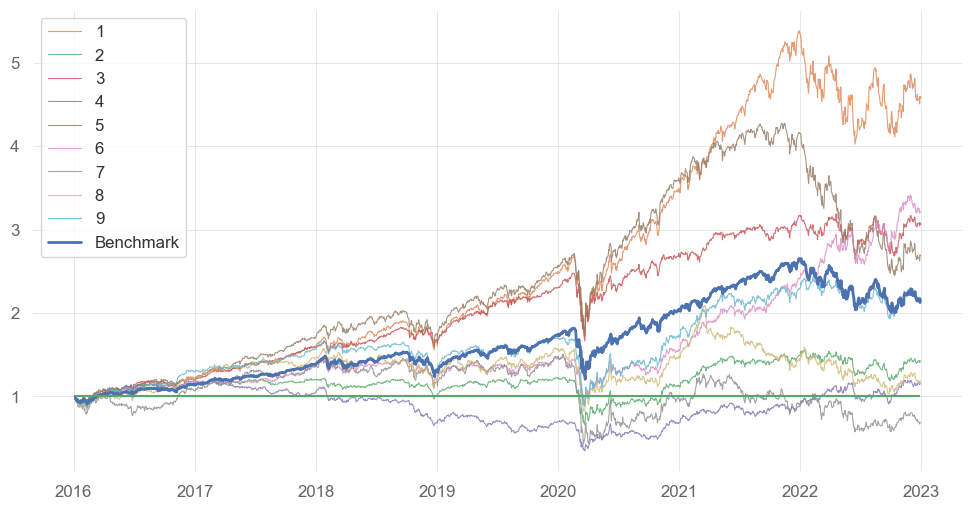

In [200]:
portfolio_evolution = pd.DataFrame(portfolio_returns.reset_index()["Date"])
plt.figure(figsize=(12, 6))
for portfolio in portfolio_returns.reset_index().columns:
    if portfolio != "Date":
        portfolio_evolution[portfolio] = (1 + portfolio_returns.reset_index()[portfolio]).cumprod()
        plt.plot(portfolio_evolution["Date"], portfolio_evolution[portfolio], label = portfolio, color = f"C{int(portfolio)}", alpha = 0.8, linewidth=0.8)
portfolio_evolution["SPY"] = (1 + benchmark.reset_index()["SPY"].pct_change()).cumprod()
plt.plot(portfolio_evolution["Date"], portfolio_evolution["SPY"], label = "Benchmark", color = f"C{int(portfolio)+1}", linewidth=2)
plt.hlines(1, xmin=min(portfolio_evolution["Date"]), xmax=max(portfolio_evolution["Date"]), color = "g")
plt.legend()
plt.show()

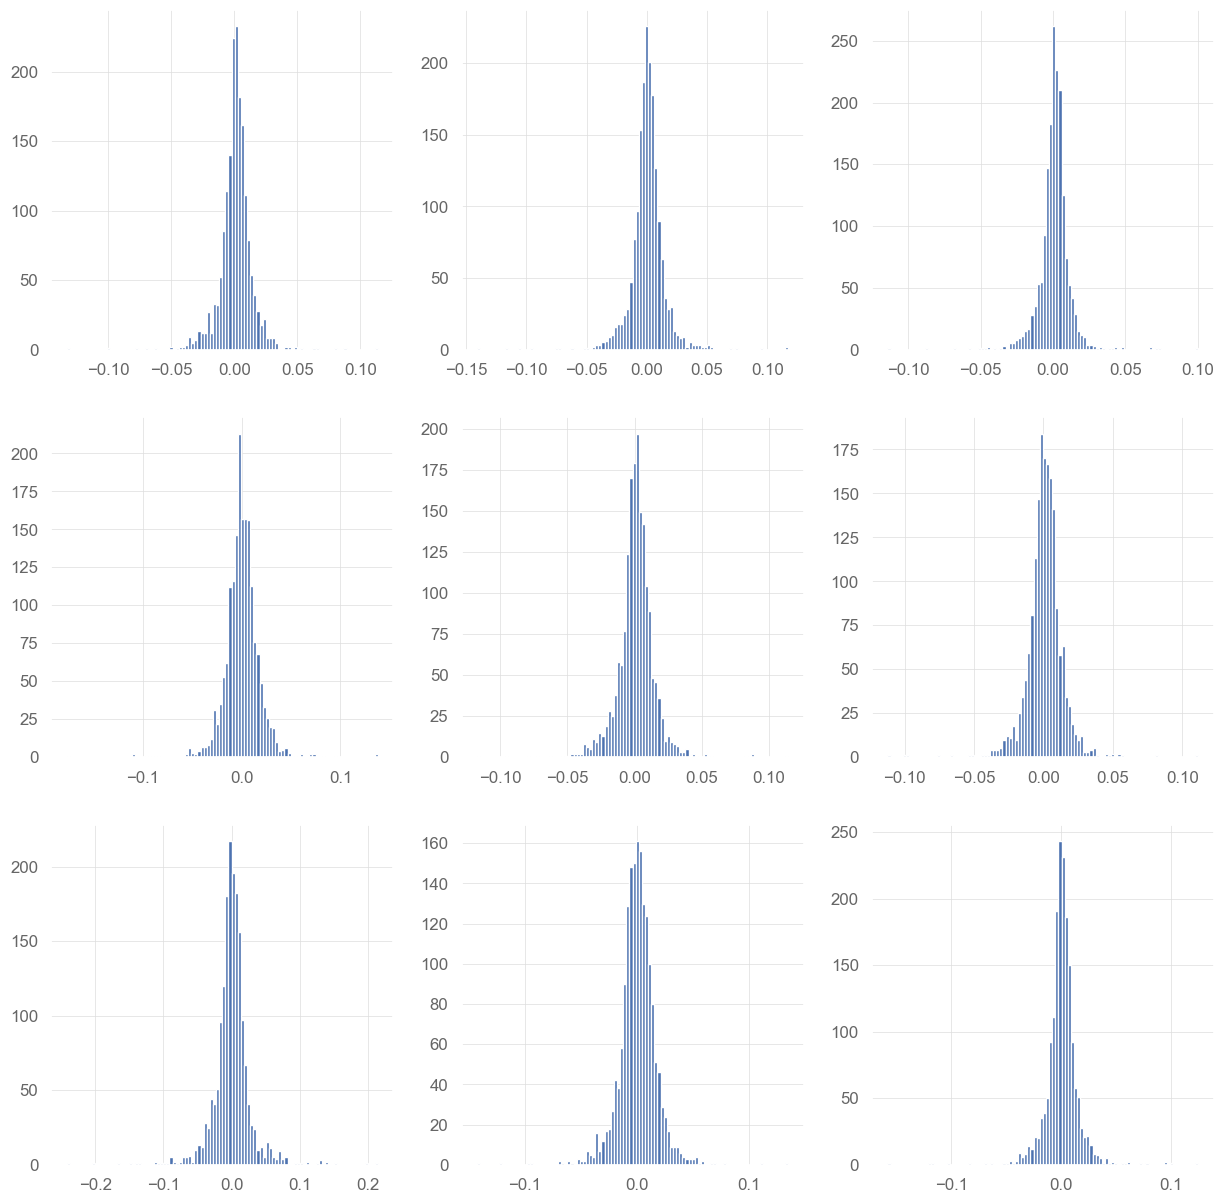

In [204]:
plt.figure(figsize=(15,15))
plots = len(portfolio_returns.columns)+1
for i in range(1, plots):
    plt.subplot(3,3,i)
    plt.hist(portfolio_returns.reset_index()[portfolio_returns.reset_index().columns[i]], bins=100)
plt.show()

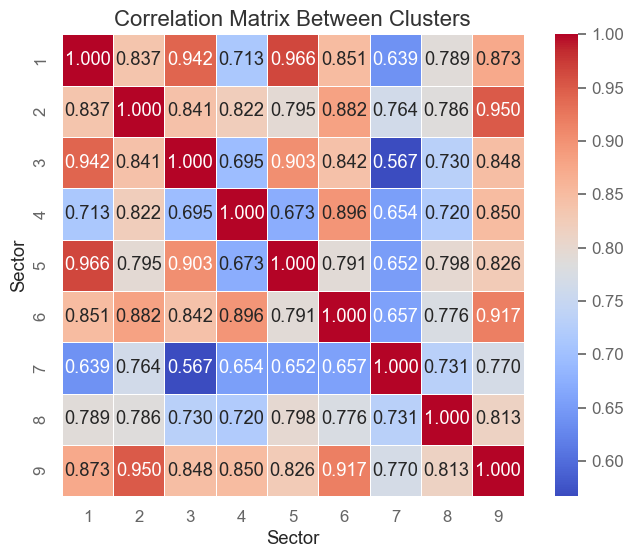

In [205]:
import seaborn as sns
cor_matrix = portfolio_returns.corr()

# 2. Create a heatmap using seaborn
plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
sns.heatmap(
    cor_matrix, 
    annot=True,  # Annotate the heatmap with the covariance values
    fmt=".3f",   # Format for the numbers
    cmap="coolwarm",  # Colormap for the heatmap
    linewidths=0.5,   # Add grid lines
    square=True       # Make the heatmap square
)

# 3. Add a title
plt.title("Correlation Matrix Between Clusters", fontsize=16)
plt.show()

In [206]:
sd_test = ed
ed_test = "2025-01-01"
portfolio_data_test = yf.download(tickers=list(stock_data["Ticker"]), start=sd_test, end=ed_test, auto_adjust=True)["Close"]

[*********************100%***********************]  480 of 480 completed


In [207]:
benchmark_test = yf.download(tickers="SPY", start=sd_test, end=ed_test, auto_adjust=True)["Close"]

[*********************100%***********************]  1 of 1 completed


In [209]:
portfolio_dataset_test = pd.DataFrame(portfolio_data_test)
missing_frac = portfolio_dataset_test.isnull().mean().sort_values(ascending=False)
drop_list = sorted(list(missing_frac[missing_frac > 0.1].index))
portfolio_dataset_test.drop(columns=drop_list, axis = 1, inplace=True)
portfolio_dataset_test.bfill(axis='index', inplace=True)
print('Null values:', portfolio_dataset_test.isnull().values.any())

Null values: False


In [210]:
# pd.merge(portfolio_dataset, final_dataframe, on="Ticker")


# Example K_means_segments DataFrame
ticker_segments = pd.DataFrame({
    "Ticker": stock_data["Ticker"],
    "Sector": stock_data["Sector"],
})

# 1. Reshape daily_prices to long format
portfolio_dataset_long = portfolio_dataset_test.reset_index().melt(id_vars="Date", var_name="Ticker", value_name="Close")

# 2. Merge with ticker_segments to get segment information
merged_data = pd.merge(portfolio_dataset_long, ticker_segments, on="Ticker")

# 3. Calculate daily returns for each ticker
merged_data["Daily_Return"] = merged_data.groupby("Ticker")["Close"].pct_change()
merged_data = merged_data.dropna()
# 4. Group by Date and K_means_segments to calculate equally weighted portfolio returns
portfolio_returns_test = (
    merged_data.groupby(["Date", "Sector"])["Daily_Return"]
    .mean()  # Equally weighted
    .reset_index()
)

# 5. Pivot the data for better visualization (optional)
portfolio_returns_test = portfolio_returns_test.pivot(
    index="Date", columns="Sector", values="Daily_Return"
).dropna()


# Print results
print("Merged Data:\n", merged_data)

Merged Data:
              Date Ticker       Close  Sector  Daily_Return
1      2023-01-04      A  149.538315       1      0.010864
2      2023-01-05      A  149.972168       1      0.002901
3      2023-01-06      A  145.594543       1     -0.029190
4      2023-01-09      A  145.397354       1     -0.001354
5      2023-01-10      A  153.048279       1      0.052621
...           ...    ...         ...     ...           ...
240955 2024-12-24    ZTS  164.203583       1      0.002557
240956 2024-12-26    ZTS  165.021118       1      0.004979
240957 2024-12-27    ZTS  164.103897       1     -0.005558
240958 2024-12-30    ZTS  161.751007       1     -0.014338
240959 2024-12-31    ZTS  162.438919       1      0.004253

[240480 rows x 5 columns]


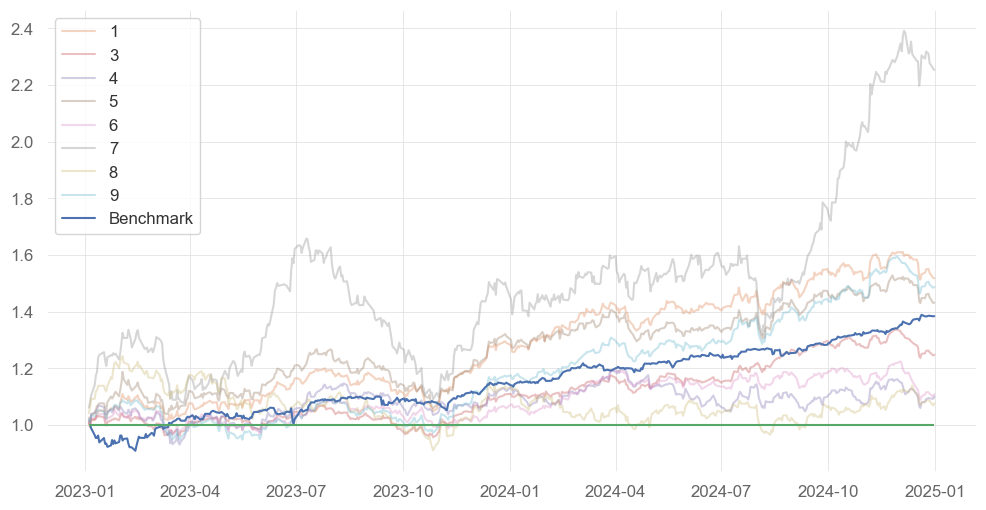

In [211]:
portfolio_evolution_test = pd.DataFrame(portfolio_returns_test.reset_index()["Date"])
plt.figure(figsize=(12, 6))
for portfolio in portfolio_returns_test.reset_index().columns:
    if portfolio != "Date" and portfolio != 2:
        portfolio_evolution_test[portfolio] = (1 + portfolio_returns_test.reset_index()[portfolio]).cumprod()
        plt.plot(portfolio_evolution_test["Date"], portfolio_evolution_test[portfolio], label = portfolio, color = f"C{int(portfolio)}", alpha = 0.35)
portfolio_evolution_test["SPY"] = (1 + benchmark.reset_index()["SPY"].pct_change()).cumprod()
plt.plot(portfolio_evolution_test["Date"], portfolio_evolution_test["SPY"], label = "Benchmark", color = f"C{int(portfolio)+1}")
plt.hlines(1, xmin=min(portfolio_evolution_test["Date"]), xmax=max(portfolio_evolution_test["Date"]), color = "g")
plt.legend()
plt.show()
# # Plot the time series

# plt.title("Portfolio Evolution Over Time", fontsize=16)
# plt.xlabel("Date", fontsize=14)
# plt.ylabel("Portfolio Value ($)", fontsize=14)
# plt.grid(True)
# plt.legend(fontsize=12)
# plt.show()

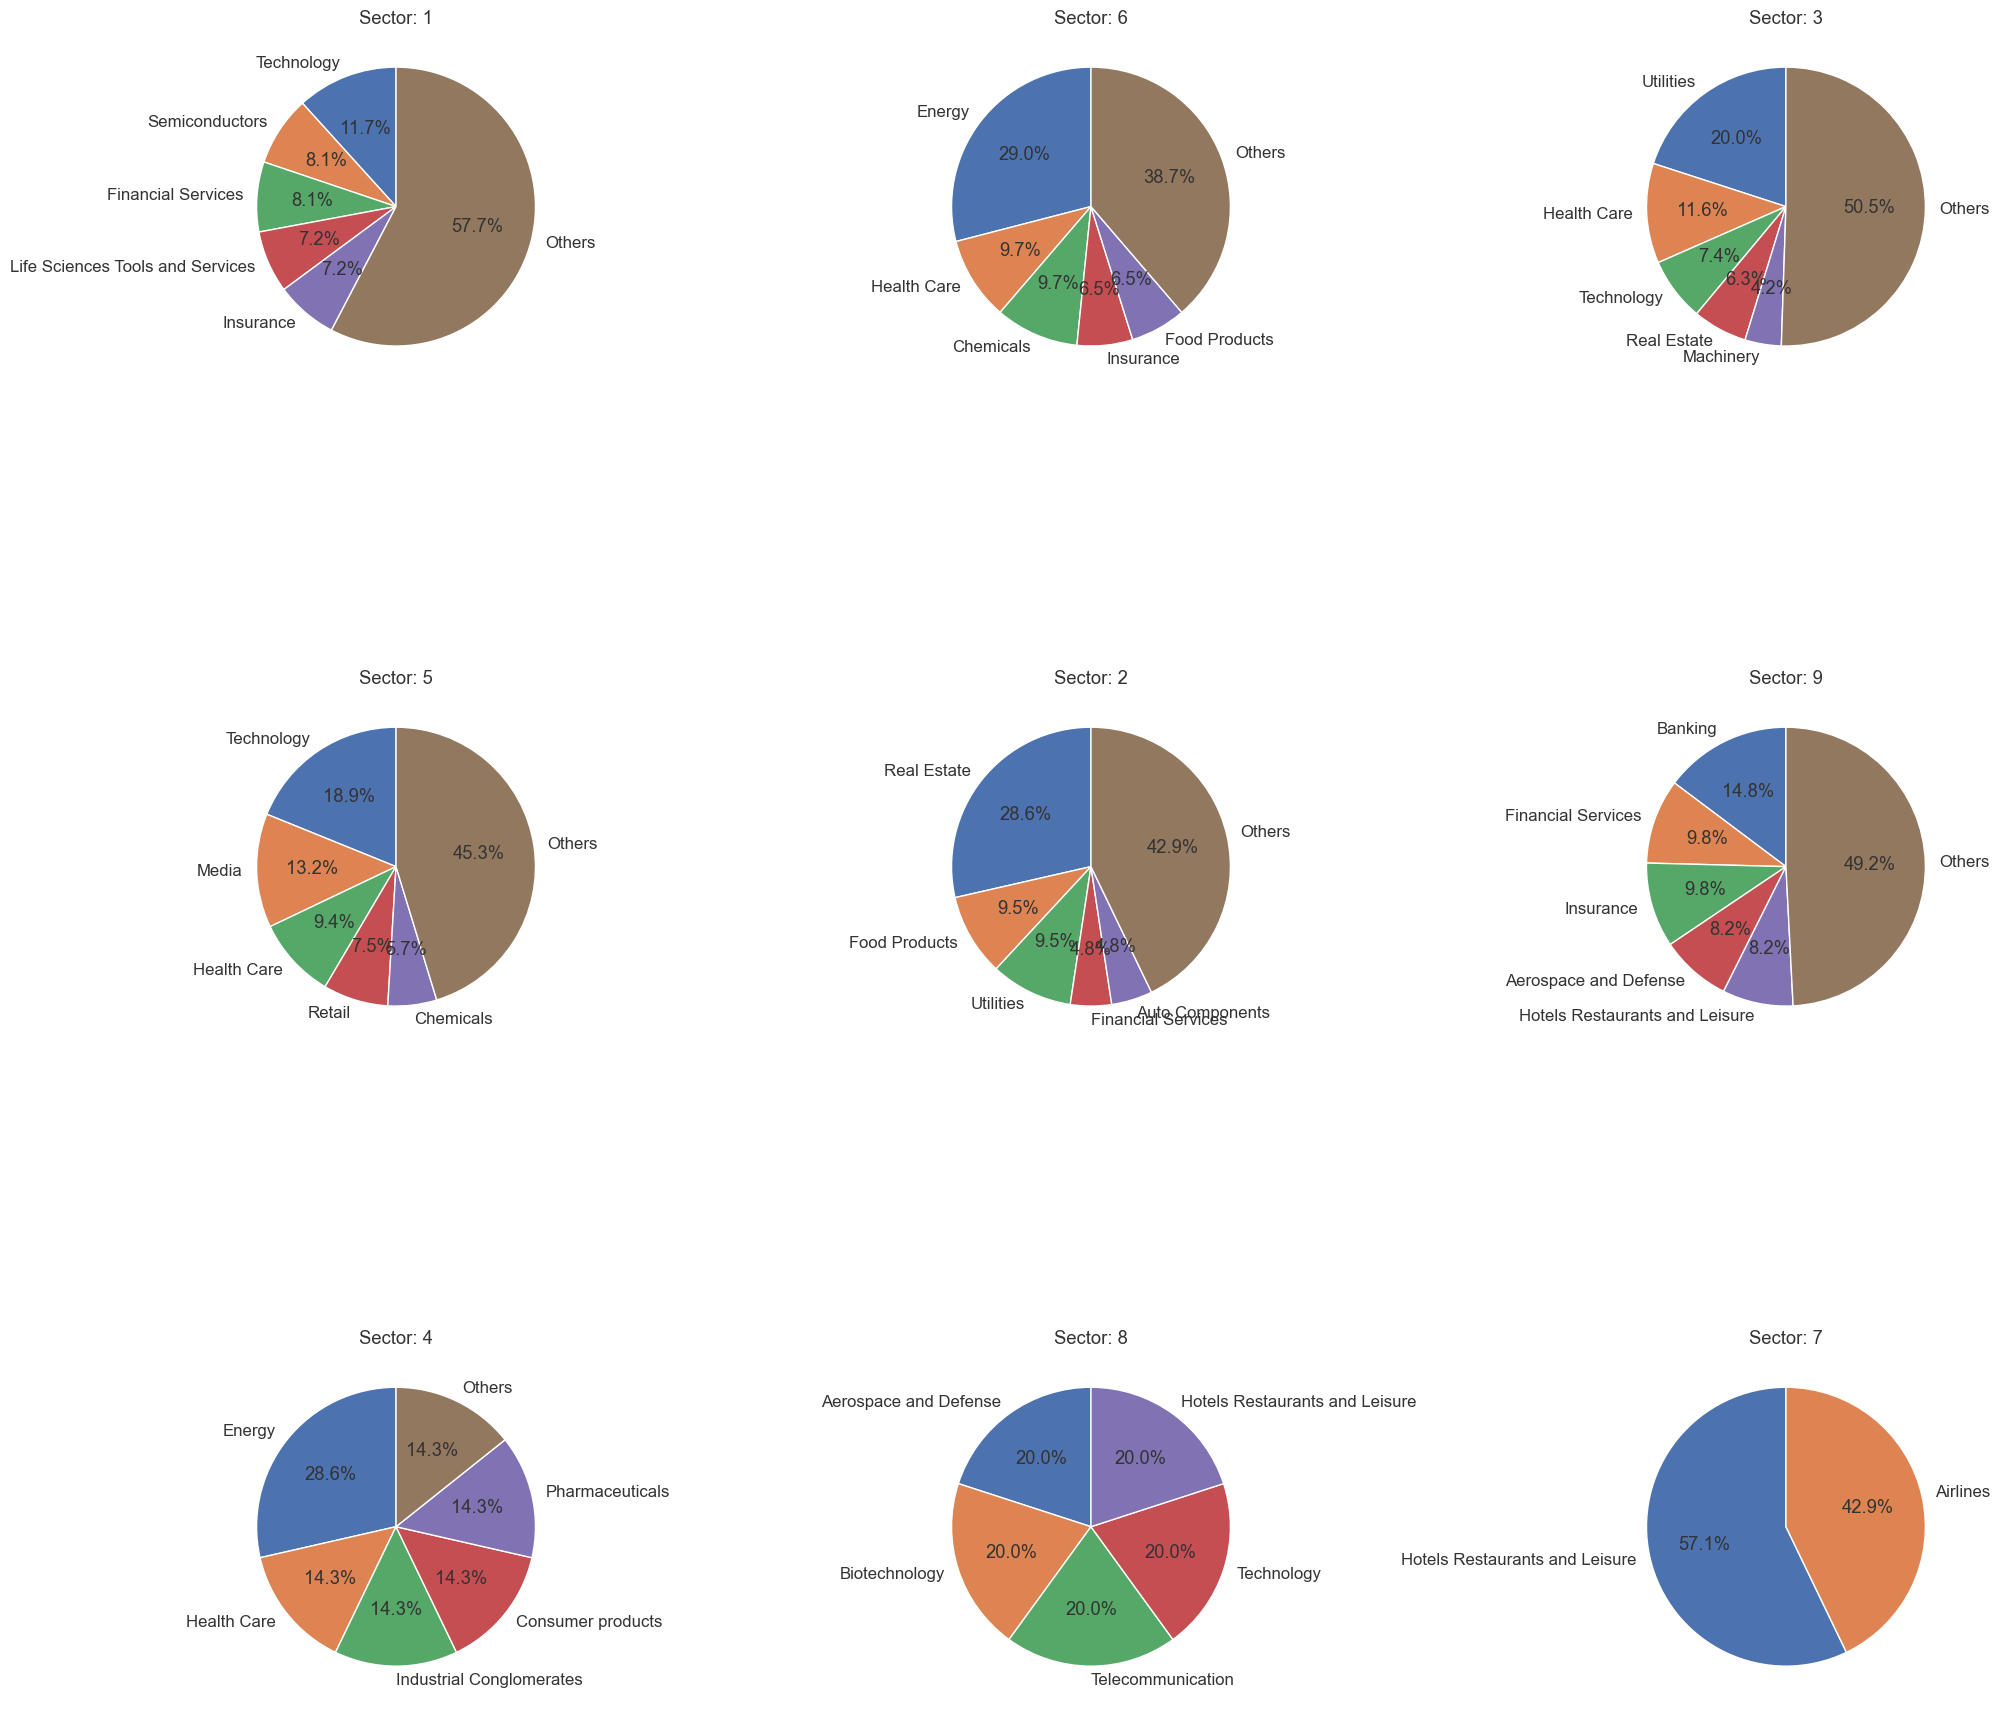

In [212]:
MAX_LABELS = 5

# Get unique sectors
sectors = stock_data["Sector"].unique()
i = 1

plt.figure(figsize=(20, 20))

for sector in sectors:
    # Count industries in the current sector
    focus = stock_data[stock_data["Sector"] == sector]["industry"].value_counts()
    
    # Group "Others" if there are too many industries
    if len(focus) > MAX_LABELS:
        others = pd.Series(focus[MAX_LABELS:].sum(), index=["Others"])
        focus = pd.concat([focus[:MAX_LABELS], others])
    
    # Plot the pie chart
    plt.subplot(3, 3, i)
    plt.pie(
        focus.values,
        labels=focus.index,
        autopct='%1.1f%%',
        startangle=90,
    )
    plt.title(f"Sector: {sector}")
    i += 1

plt.tight_layout()
plt.show()

In [217]:
def weights(ratios, cluster, pow, thresh):
    sw = ratios["Sharpe_ratio"]*(ratios["Sharpe_ratio"] > thresh)
    ratios["weights"] = np.power(sw, pow)
    ratios["weights"] = ratios["weights"]/np.sum(ratios["weights"])
    return ratios.loc[ratios["Sector"] == cluster, "weights"]

In [235]:
import quantstats as qs

returns = np.zeros(len(portfolio_returns_test))
cp = cluster_profile.reset_index()
for i in portfolio_returns_test.columns:
        returns += weights(cp[["Sector", "Sharpe_ratio"]], i, 1, 0.0).values[0]*portfolio_returns_test[i] 
portfolio_performance_test = pd.DataFrame(returns).reset_index()
portfolio_performance_test

C:\Users\m.narese\AppData\Local\Temp\ipykernel_11316\196017028.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratios["weights"] = np.power(sw, pow)
C:\Users\m.narese\AppData\Local\Temp\ipykernel_11316\196017028.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratios["weights"] = ratios["weights"]/np.sum(ratios["weights"])
C:\Users\m.narese\AppData\Local\Temp\ipykernel_11316\196017028.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

,Date,1
0,2023-01-04,0.014927
1,2023-01-05,-0.009060
2,2023-01-06,0.024298
3,2023-01-09,0.000257
4,2023-01-10,0.007268
...,...,...
496,2024-12-24,0.007774
497,2024-12-26,0.001128
498,2024-12-27,-0.006750
499,2024-12-30,-0.009779


                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2023-01-05   2023-01-05
End Period                 2024-12-31   2024-12-31
Risk-Free Rate             2.0%         2.0%
Time in Market             100.0%       100.0%

Cumulative Return          57.03%       32.34%
CAGR﹪                     16.96%       10.22%

Sharpe                     1.68         1.02
Prob. Sharpe Ratio         98.26%       88.42%
Smart Sharpe               1.58         0.95
Sortino                    2.5          1.49
Smart Sortino              2.34         1.39
Sortino/√2                 1.77         1.05
Smart Sortino/√2           1.66         0.98
Omega                      1.18         1.18

Max Drawdown               -9.97%       -12.12%
Longest DD Days            121          147
Volatility (ann.)          12.82%       12.76%
R^2                        0.75         0.75
Information Ratio          -0.08        -0.08
Calmar            

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2023-08-01,2023-10-27,2023-12-12,134,-12.124782,-11.487093
2,2023-02-03,2023-03-17,2023-06-29,147,-9.371437,-9.113698
3,2024-12-02,2024-12-19,2024-12-31,30,-7.399758,-6.935637
4,2024-04-01,2024-04-18,2024-07-11,102,-5.836992,-5.778333
5,2024-08-01,2024-08-05,2024-08-16,16,-5.224723,-5.049811


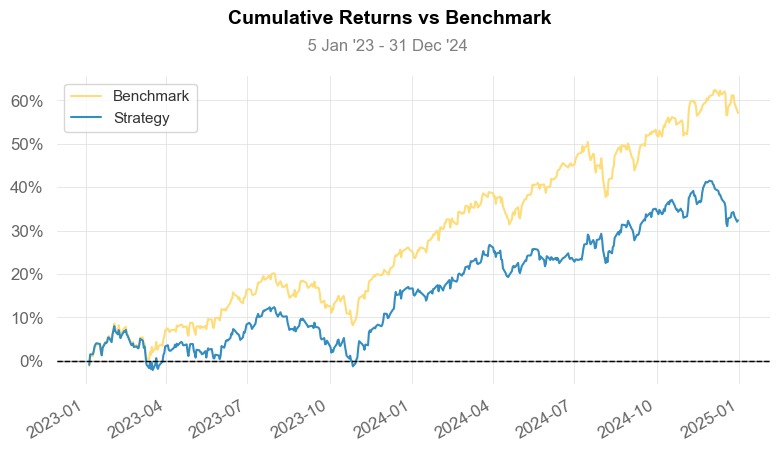

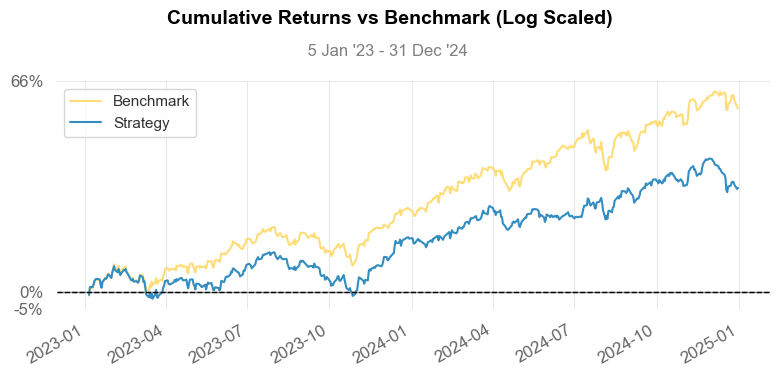

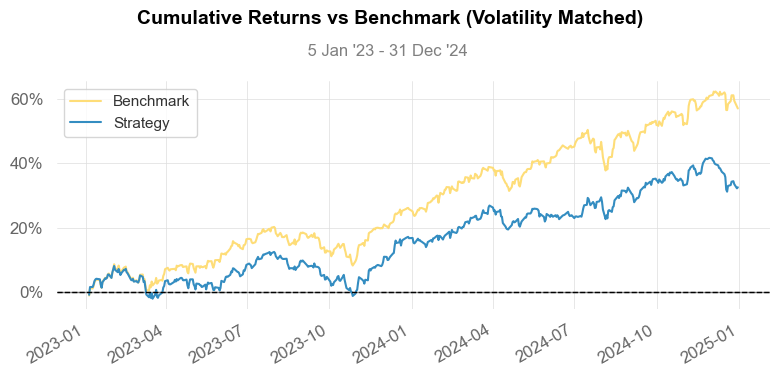

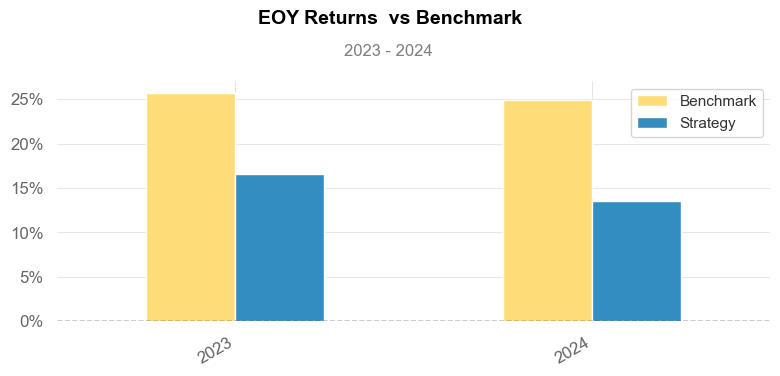

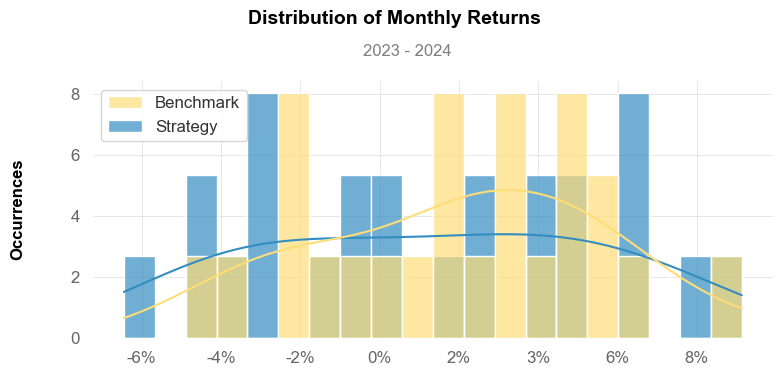

C:\Users\m.narese\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\quantstats\_plotting\core.py:294: FutureWarning: Passing additional kwargs to DatetimeIndexResampler.sum has no impact on the result and is deprecated. This will raise a TypeError in a future version of pandas.
  returns = returns.last() if compound is True else returns.sum(axis=0)


UnsupportedFunctionCall: numpy operations are not valid with resample. Use .resample(...).sum() instead

In [236]:
portfolio_performance_test["Date"] = pd.to_datetime(portfolio_performance_test["Date"])

# Set "Date" as the index
portfolio_performance_test.set_index("Date", inplace=True)

# Rename the column for better clarity (optional)
portfolio_performance_test.columns = ["Returns"]

# Ensure the returns are properly formatted and call the quantstats report
qs.reports.full(portfolio_performance_test["Returns"], benchmark="SPY", rf=0.02)

In [128]:
def weights(ratios, cluster, pow):
    ratios["weights"] = np.power(ratios["Sharpe_ratio"], pow)
    ratios["weights"] = ratios["weights"]/np.sum(ratios["weights"])
    return ratios.loc[ratios["Sector"] == cluster, "weights"]

In [131]:
import quantstats as qs

returns = np.zeros(len(portfolio_returns))
cp = cluster_profile.reset_index()
for i in portfolio_returns.columns:
        returns += weights(cp[["Sector", "Sharpe_ratio"]], i, 3).values[0]*portfolio_returns[i] 
portfolio_performance = pd.DataFrame(returns).reset_index()
portfolio_performance

C:\Users\m.narese\AppData\Local\Temp\ipykernel_11316\84710039.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratios["weights"] = np.power(ratios["Sharpe_ratio"], pow)
C:\Users\m.narese\AppData\Local\Temp\ipykernel_11316\84710039.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratios["weights"] = ratios["weights"]/np.sum(ratios["weights"])
C:\Users\m.narese\AppData\Local\Temp\ipykernel_11316\84710039.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Tr

,Date,1.0
0,2024-01-03,-0.013002
1,2024-01-04,-0.002262
2,2024-01-05,0.001391
3,2024-01-08,0.010995
4,2024-01-09,-0.003980
...,...,...
261,2025-01-17,0.004304
262,2025-01-21,0.011121
263,2025-01-22,-0.004035
264,2025-01-23,0.005768


                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2024-01-04   2024-01-04
End Period                 2025-01-24   2025-01-24
Risk-Free Rate             2.0%         2.0%
Time in Market             100.0%       100.0%

Cumulative Return          31.35%       11.4%
CAGR﹪                     19.49%       7.3%

Sharpe                     1.96         0.77
Prob. Sharpe Ratio         96.24%       73.76%
Smart Sharpe               1.87         0.74
Sortino                    2.86         1.1
Smart Sortino              2.73         1.05
Sortino/√2                 2.02         0.77
Smart Sortino/√2           1.93         0.74
Omega                      1.13         1.13

Max Drawdown               -8.41%       -7.61%
Longest DD Days            64           106
Volatility (ann.)          12.63%       11.57%
R^2                        0.68         0.68
Information Ratio          -0.14        -0.14
Calmar                 

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2024-12-03,2025-01-10,2025-01-24,53,-7.605724,-7.447656
2,2024-04-01,2024-04-18,2024-07-15,106,-5.873458,-5.760922
3,2024-07-17,2024-08-07,2024-08-22,37,-5.749165,-5.652831
4,2024-10-15,2024-10-31,2024-11-22,39,-4.186061,-4.095475
5,2024-09-03,2024-09-06,2024-09-18,16,-3.534150,-2.708799


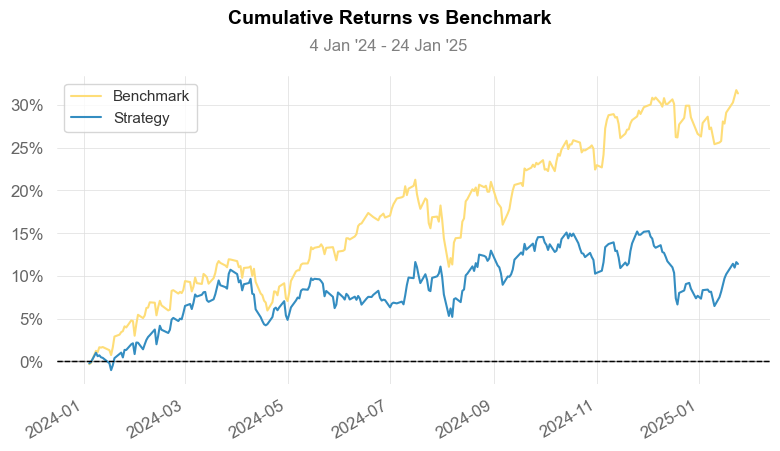

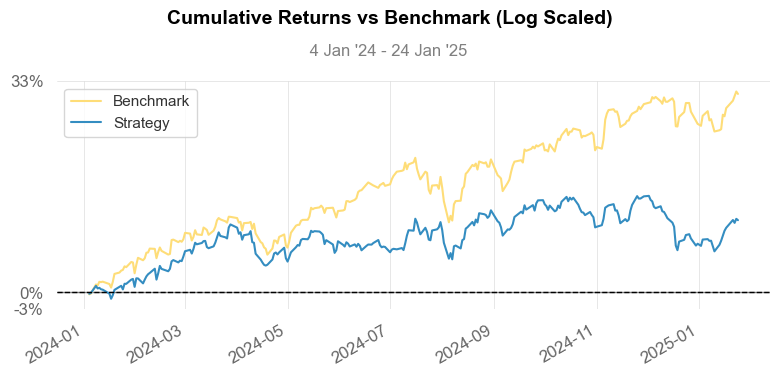

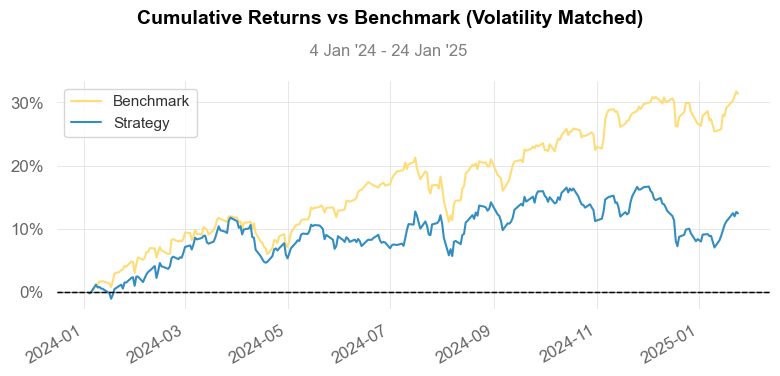

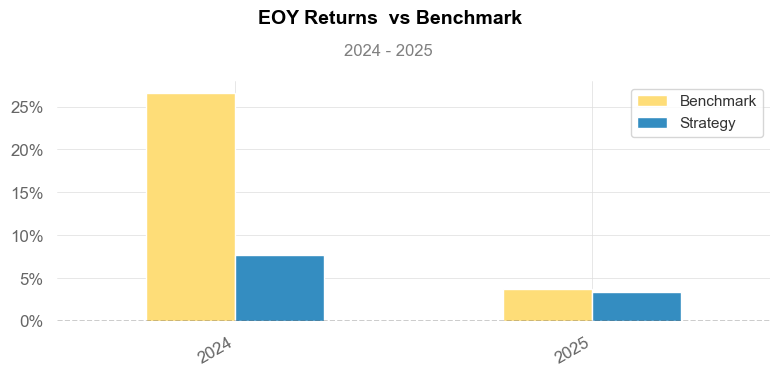

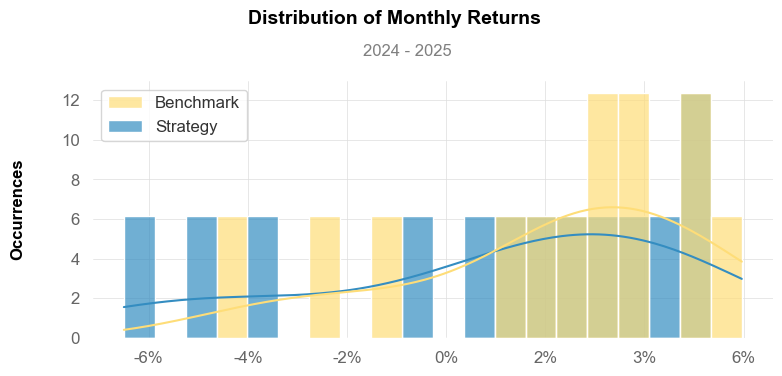

C:\Users\m.narese\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\quantstats\_plotting\core.py:294: FutureWarning: Passing additional kwargs to DatetimeIndexResampler.sum has no impact on the result and is deprecated. This will raise a TypeError in a future version of pandas.
  returns = returns.last() if compound is True else returns.sum(axis=0)


UnsupportedFunctionCall: numpy operations are not valid with resample. Use .resample(...).sum() instead

In [132]:
portfolio_performance["Date"] = pd.to_datetime(portfolio_performance["Date"])

# Set "Date" as the index
portfolio_performance.set_index("Date", inplace=True)

# Rename the column for better clarity (optional)
portfolio_performance.columns = ["Returns"]

# Ensure the returns are properly formatted and call the quantstats report
qs.reports.full(portfolio_performance["Returns"], benchmark="SPY", rf=0.02)